In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from pathlib import Path
import sys
parentDir = Path.cwd().parent
sys.path.insert(0, str(parentDir))
from utils.preprocess import load_ninapro_data, preprocess_emg
dataPath = parentDir / "data" / "raw" / "ninapro-db2"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
subject_number = 17
exercise_number = 1
channel_to_plot = 2

In [55]:
emg, stimulus, repetition, time, Fs = load_ninapro_data(subject_number=subject_number, exercise_number=exercise_number, dataPath=dataPath)

In [56]:
filtered_emg = preprocess_emg(emg[:, channel_to_plot], Fs, smoothen=True, lowcut=20.0, highcut=450.0, smooth_window=0.05, normalize=True)

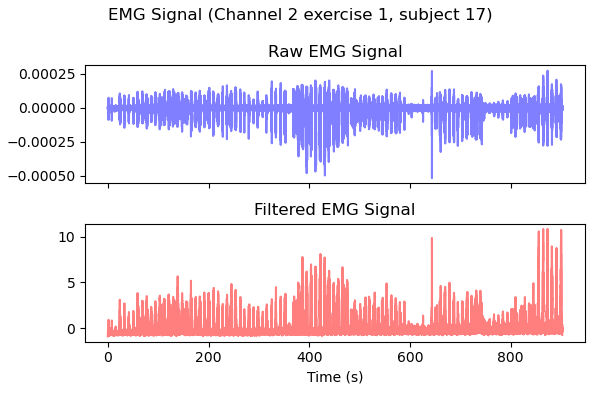

In [57]:
 # Plot raw and filtered EMG signals for comparison

fig, axs = plt.subplots(2,1, figsize=(6, 4), sharex=True)
axs[0].plot(time, emg[:, channel_to_plot], color='blue', label='Raw EMG', alpha=0.5)
axs[1].plot(time, filtered_emg, color='red', label='Filtered EMG', alpha=0.5)
plt.suptitle(f'EMG Signal (Channel {channel_to_plot} exercise {exercise_number}, subject {subject_number})')
plt.xlabel('Time (s)')
axs[0].set_title('Raw EMG Signal')
axs[1].set_title('Filtered EMG Signal')
# plt.ylabel('Amplitude')
# plt.legend()
plt.tight_layout()
plt.show()

In [58]:
# Preprocess all channels
emg_clean = np.zeros_like(emg)
for ch in range(emg.shape[1]):
    emg_clean[:, ch] = preprocess_emg(emg[:, ch], Fs, smoothen=True, lowcut=20.0, highcut=450.0, smooth_window=0.05, normalize=True)

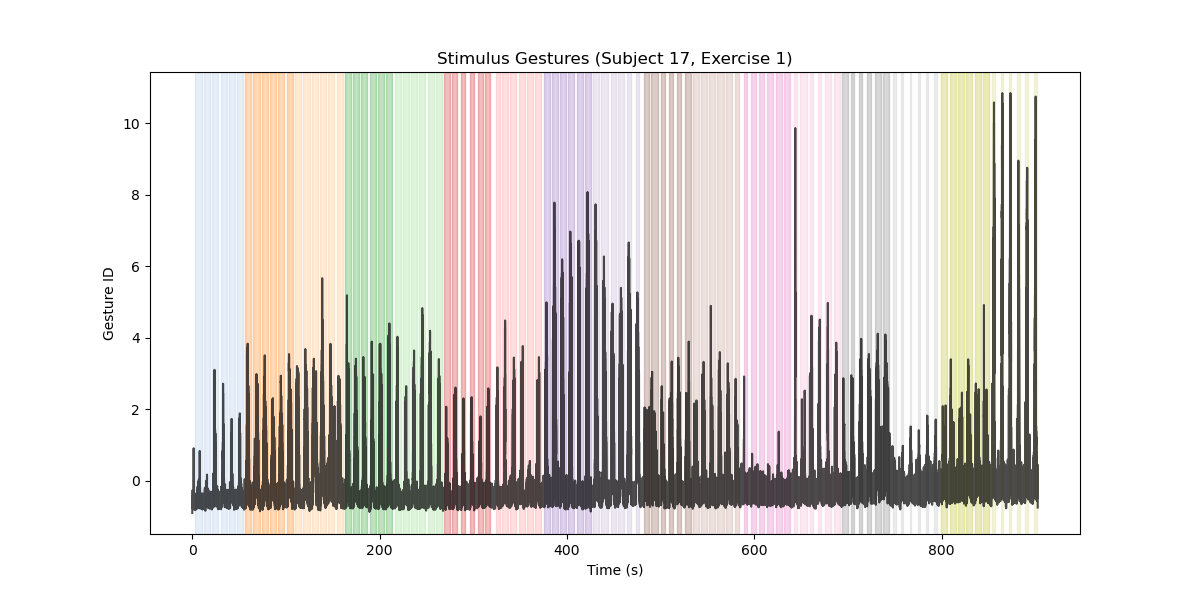

In [71]:
# plot stimulus gesture
plt.figure(figsize=(12, 6))
# Overlap shaded regions for each gesture
unique_gestures = np.unique(stimulus)
# Plot all gesture repetitions
for gesture_id in unique_gestures:
    if gesture_id == 0:
            continue # Skip rest gesture
    for repetition_id in range(1, 7):  # Assuming 6 repetitions
        # Find start and end indices of the gesture repetition
        mask = (stimulus == gesture_id) & (repetition == repetition_id)
        if np.any(mask):
            start_idx = np.where(mask)[0][0]
            end_idx = np.where(mask)[0][-1]
        plt.axvspan(time[start_idx], time[end_idx], color=plt.cm.tab20(gesture_id % 20), alpha=0.3, label=f' {gesture_id}')
# plot emg channel
plt.plot(time, emg_clean[:, channel_to_plot], color='black', label='EMG Channel', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Gesture ID')
plt.title(f'Stimulus Gestures (Subject {subject_number}, Exercise {exercise_number})')
# Put legend outside the plot
# plt.gca().legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.legend(loc ='upper right', bbox_to_anchor=(1.15, 1))
plt.show()


In [23]:
fs = 2000
win_s, step_s = 200, 100
win = int(fs * win_s / 1000)
step = int(fs * step_s / 1000)

X, y, reps = [], [], []

for g in np.unique(stimulus):
    for r in np.unique(repetition[stimulus == g]):
        idx = np.where((stimulus == g) & (repetition == r))[0]
        for i in range(0, len(idx)-win, step):
            seg = emg_clean[idx[i:i+win], :]
            if seg.shape[0] == win:
                X.append(seg)
                y.append(g)
                reps.append(r)

X, y, reps = np.array(X), np.array(y), np.array(reps)
print("X:", X.shape, "y:", y.shape, "reps:", np.unique(reps))


X: (8881, 400, 12) y: (8881,) reps: [0 1 2 3 4 5 6]
